# The second attempt

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np
from helper_functions import *

We will once again be getting data from cryptodatadownload.com and more specifically from the binance exchange:
http://www.cryptodatadownload.com/data/binance/

This time I will be training and running the model on the past 90 days of data, which will approximately be the final length of the twitter collection period.

I have been thinking about it and I beleive I will either utilize or implement a price scraping tool, there are several guides online and it would both increase the reliability of the data (e.g. I currently have no source for hourly dogecoin prices) and also open up the ability to create a single function which creates a dataset including price and twitter data over a timeperiod (simplifying things). Also means I could maintain 'master' lists of prices which could be appended to (by a function) and avoid needing to manually download and process CSV files.

This isn't very high priority though and will be something I leave until the Easter break.

In [2]:
#Importing the dataset and inspection
current_folder = os.path.abspath('')
csv_file_path = os.path.join(current_folder, "Data", "10-03-21-binance-btc-1hr.csv")

# creating a pandas dataframe from CSV
df = pd.read_csv(csv_file_path)

# dataframe is sorted from newst to oldest, reverse order:
df = df[::-1]
print(df.shape)
df.iloc[0]

(2627, 10)


unix                 1605855600000
date           2020-11-20 07:00:00
symbol                    BTC/USDT
open                       18164.8
high                       18404.7
low                        18089.7
close                        18212
Volume BTC                 6097.87
Volume USDT            1.11205e+08
tradecount                   93118
Name: 2626, dtype: object

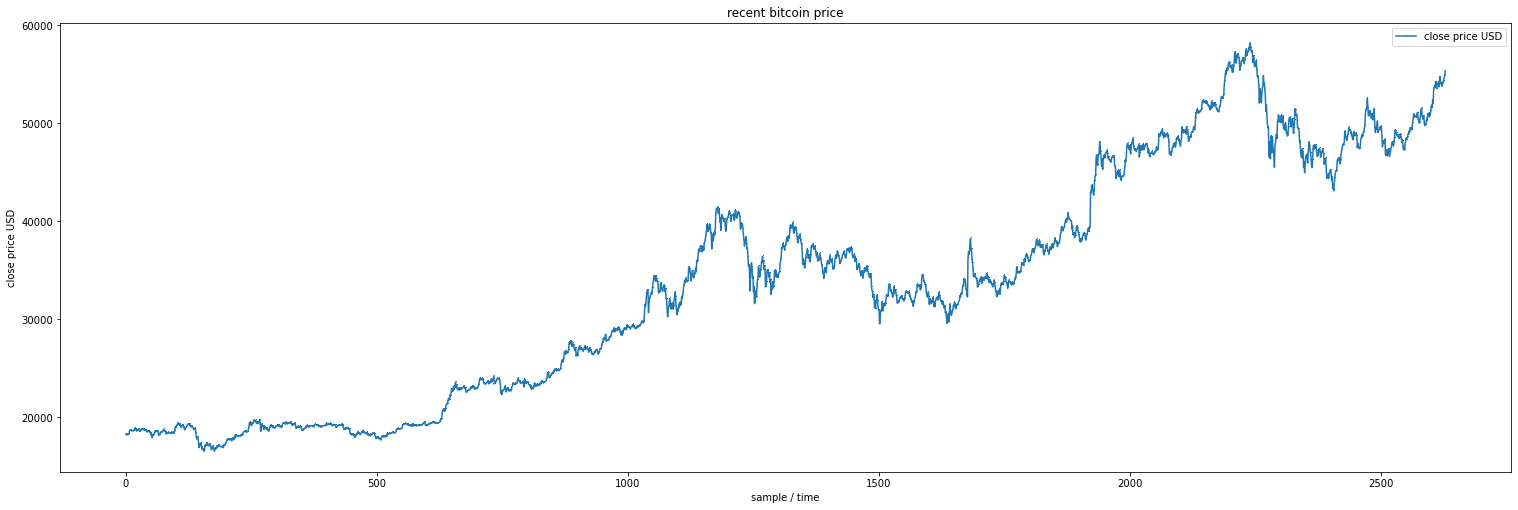

In [3]:
plot_simple_timeseries_data(df['close'], "close price USD", "recent bitcoin price")

I manually cropped the data to the period where the accuracy increase occurred (discussed last time). The data now covers the period:`2020-11-20 07:00:00` to `2021-03-10 00:00:00`. 

I will now try and work out a way of only consiering the 

we will look at data from 2021-03-10 and 90 days previous

In [4]:
from datetime import date, timedelta

end_point = date(2021, 3, 10)
start_point = end_point - timedelta(91)

print(start_point)
print(end_point)

2020-12-09
2021-03-09


In [5]:
print(df.iloc[0, 1])
print(type(df.iloc[0, 1]))

2020-11-20 07:00:00
<class 'str'>


In [6]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

In [7]:
print(df.iloc[0, 1])
print(type(df.iloc[0, 1]))

2020-11-20 07:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [8]:
if df.iloc[0, 1] > pd.to_datetime('2020-11-20'):
    print('true')
else:
    print('false')

true


In [9]:
filter_dates = df['date'] >= pd.to_datetime(start_point)
timeperiod_df = df[filter_dates]
filter_dates = timeperiod_df['date'] < pd.to_datetime(end_point)
timeperiod_df = timeperiod_df[filter_dates]

In [10]:
print(timeperiod_df.iloc[0])
print(timeperiod_df.iloc[-1])


unix                 1607472000000
date           2020-12-09 00:00:00
symbol                    BTC/USDT
open                       18324.1
high                         18380
low                          18120
close                        18180
Volume BTC                 4284.97
Volume USDT            7.82902e+07
tradecount                   72252
Name: 2178, dtype: object
unix                 1615330800000
date           2021-03-09 23:00:00
symbol                    BTC/USDT
open                       54808.8
high                         54895
low                          54475
close                      54884.5
Volume BTC                 1948.88
Volume USDT            1.06591e+08
tradecount                   68074
Name: 1, dtype: object


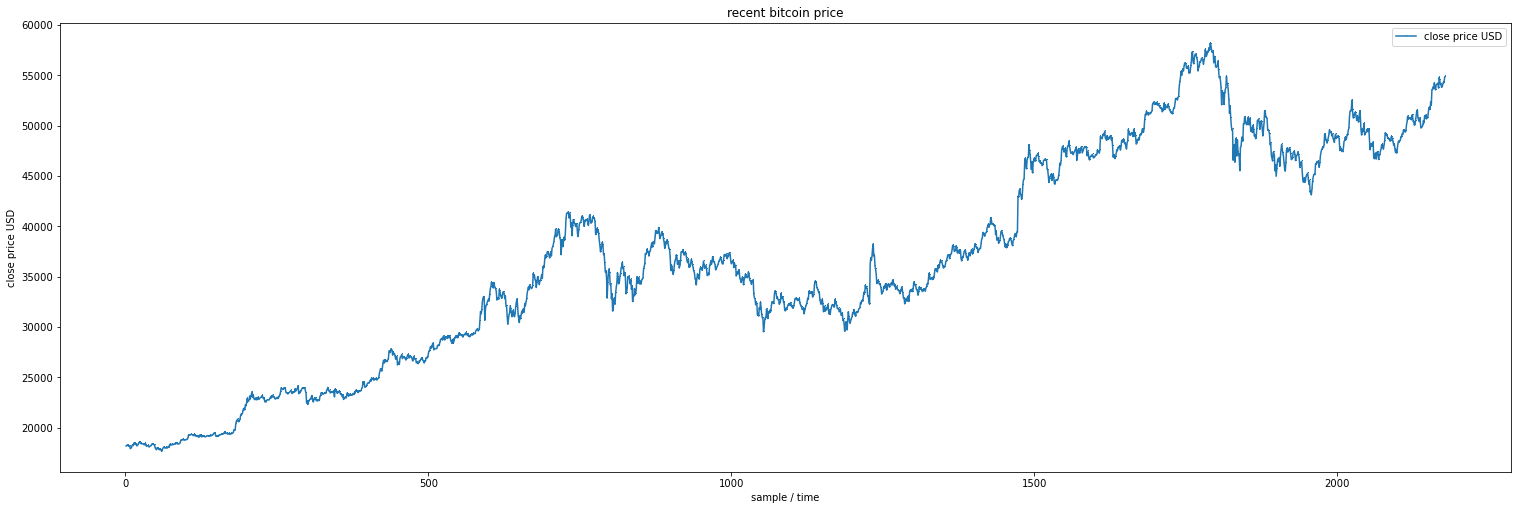

In [11]:
plot_simple_timeseries_data(timeperiod_df['close'], "close price USD", "recent bitcoin price")


In [12]:
timeperiod_df.shape

(2178, 10)

In [13]:
timeperiod_df = timeperiod_df.drop(columns=['unix', 'date', 'symbol', 'Volume USDT', 'tradecount'])

In [14]:
timeperiod_df.iloc[0]

open          18324.110000
high          18380.000000
low           18120.000000
close         18180.010000
Volume BTC     4284.974779
Name: 2178, dtype: float64

In [15]:
training_samples = 1178
validation_samples = 500

timeperiod_df = normalise_data(timeperiod_df, training_samples, validation_samples)

lookback = 120
step = 1
delay = 24
batch_size = 128

train_dataset, val_dataset, test_dataset = create_datasets(timeperiod_df, 3, training_samples, validation_samples, lookback, step, delay, batch_size)

final sample - training: 12000th, validation: 19000th, test: 2178th


In [16]:
shape_1, shape_2 = get_dataset_shape(train_dataset)

Input shape: (128, 120, 5)
Target shape: (128, 1)


In [17]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model1 = models.Sequential()
model1.add(layers.GRU(32, return_sequences=True, input_shape=(shape_1, shape_2)))

model1.add(layers.GRU(32, activation='relu'))


model1.add(layers.Dense(1))

model1.compile(optimizer=RMSprop(), loss='mae')
model1_history = model1.fit(train_dataset, epochs=40, validation_data=val_dataset)

Epoch 1/40
9/9 [==============================] - 6s 383ms/step - loss: 0.8096 - val_loss: 0.5068
Epoch 2/40
9/9 [==============================] - 2s 254ms/step - loss: 0.3310 - val_loss: 0.5092
Epoch 3/40
9/9 [==============================] - 2s 237ms/step - loss: 0.1617 - val_loss: 0.5044
Epoch 4/40
9/9 [==============================] - 2s 248ms/step - loss: 0.1544 - val_loss: 0.4941
Epoch 5/40
9/9 [==============================] - 2s 245ms/step - loss: 0.1521 - val_loss: 0.4863
Epoch 6/40
9/9 [==============================] - 2s 250ms/step - loss: 0.1474 - val_loss: 0.4780
Epoch 7/40
9/9 [==============================] - 2s 268ms/step - loss: 0.1432 - val_loss: 0.4728
Epoch 8/40
9/9 [==============================] - 2s 248ms/step - loss: 0.1419 - val_loss: 0.4734
Epoch 9/40
9/9 [==============================] - 2s 258ms/step - loss: 0.1407 - val_loss: 0.4665
Epoch 10/40
9/9 [==============================] - 2s 253ms/step - loss: 0.1395 - val_loss: 0.4693
Epoch 11/40
9/9 [==

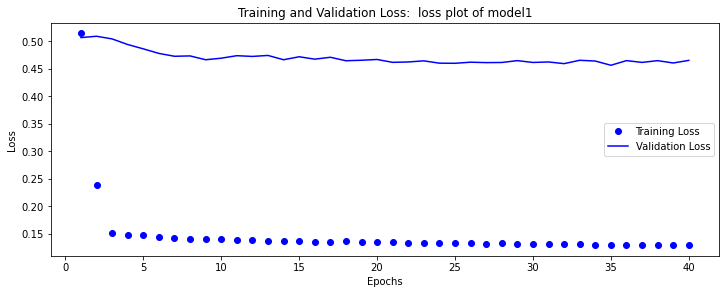

In [18]:
plot_simple_loss(model1_history, "loss plot of model1")

In [19]:
model2 = models.Sequential()
model2.add(layers.GRU(32, return_sequences=True, input_shape=(shape_1, shape_2)))

model2.add(layers.GRU(16, activation='relu'))


model2.add(layers.Dense(1))

model2.compile(optimizer=RMSprop(), loss='mae')
model2_history = model2.fit(train_dataset, epochs=40, validation_data=val_dataset)

Epoch 1/40
9/9 [==============================] - 6s 299ms/step - loss: 1.1205 - val_loss: 0.6586
Epoch 2/40
9/9 [==============================] - 2s 234ms/step - loss: 0.7136 - val_loss: 0.6629
Epoch 3/40
9/9 [==============================] - 2s 249ms/step - loss: 0.4899 - val_loss: 0.6648
Epoch 4/40
9/9 [==============================] - 2s 256ms/step - loss: 0.2681 - val_loss: 0.6583
Epoch 5/40
9/9 [==============================] - 2s 239ms/step - loss: 0.1916 - val_loss: 0.6502
Epoch 6/40
9/9 [==============================] - 2s 231ms/step - loss: 0.1619 - val_loss: 0.6400
Epoch 7/40
9/9 [==============================] - 2s 243ms/step - loss: 0.1604 - val_loss: 0.6244
Epoch 8/40
9/9 [==============================] - 2s 242ms/step - loss: 0.1635 - val_loss: 0.6121
Epoch 9/40
9/9 [==============================] - 2s 236ms/step - loss: 0.1525 - val_loss: 0.6006
Epoch 10/40
9/9 [==============================] - 2s 231ms/step - loss: 0.1541 - val_loss: 0.5869
Epoch 11/40
9/9 [==

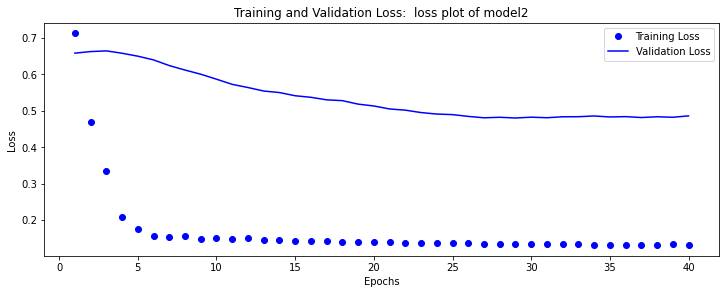

In [20]:
plot_simple_loss(model2_history, "loss plot of model2")

In [21]:
model3 = models.Sequential()
model3.add(layers.GRU(32, return_sequences=True, input_shape=(shape_1, shape_2)))

model3.add(layers.GRU(32, activation='relu'))


model3.add(layers.Dense(1))

model3.compile(optimizer=RMSprop(), loss='mae')
model3_history = model3.fit(train_dataset, epochs=40, validation_data=val_dataset)

Epoch 1/40
9/9 [==============================] - 6s 309ms/step - loss: 1.0211 - val_loss: 0.6500
Epoch 2/40
9/9 [==============================] - 2s 239ms/step - loss: 0.6422 - val_loss: 0.6220
Epoch 3/40
9/9 [==============================] - 2s 258ms/step - loss: 0.2950 - val_loss: 0.6013
Epoch 4/40
9/9 [==============================] - 2s 252ms/step - loss: 0.2324 - val_loss: 0.5875
Epoch 5/40
9/9 [==============================] - 2s 242ms/step - loss: 0.1788 - val_loss: 0.5692
Epoch 6/40
9/9 [==============================] - 2s 252ms/step - loss: 0.1742 - val_loss: 0.5573
Epoch 7/40
9/9 [==============================] - 2s 239ms/step - loss: 0.1700 - val_loss: 0.5489
Epoch 8/40
9/9 [==============================] - 2s 256ms/step - loss: 0.1622 - val_loss: 0.5402
Epoch 9/40
9/9 [==============================] - 2s 233ms/step - loss: 0.1563 - val_loss: 0.5342
Epoch 10/40
9/9 [==============================] - 3s 308ms/step - loss: 0.1536 - val_loss: 0.5274
Epoch 11/40
9/9 [==

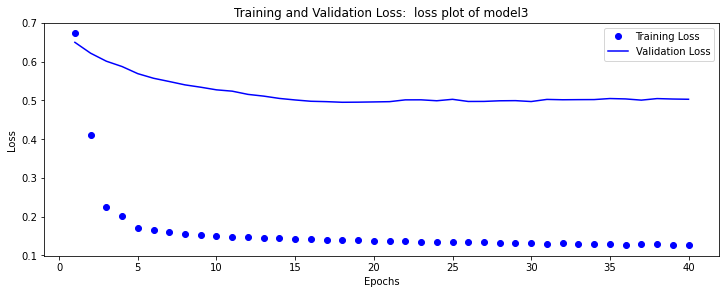

In [22]:
plot_simple_loss(model3_history, "loss plot of model3")

In [23]:
model4 = models.Sequential()
model4.add(layers.GRU(16, return_sequences=True, input_shape=(shape_1, shape_2)))

model4.add(layers.GRU(16, activation='relu'))


model4.add(layers.Dense(1))

model4.compile(optimizer=RMSprop(), loss='mae')
model4_history = model4.fit(train_dataset, epochs=40, validation_data=val_dataset)

Epoch 1/40
9/9 [==============================] - 7s 299ms/step - loss: 0.4760 - val_loss: 0.4666
Epoch 2/40
9/9 [==============================] - 2s 228ms/step - loss: 0.2357 - val_loss: 0.4665
Epoch 3/40
9/9 [==============================] - 2s 230ms/step - loss: 0.1828 - val_loss: 0.4662
Epoch 4/40
9/9 [==============================] - 2s 220ms/step - loss: 0.1595 - val_loss: 0.4667
Epoch 5/40
9/9 [==============================] - 2s 228ms/step - loss: 0.1457 - val_loss: 0.4672
Epoch 6/40
9/9 [==============================] - 2s 219ms/step - loss: 0.1413 - val_loss: 0.4684
Epoch 7/40
9/9 [==============================] - 2s 215ms/step - loss: 0.1409 - val_loss: 0.4669
Epoch 8/40
9/9 [==============================] - 2s 206ms/step - loss: 0.1384 - val_loss: 0.4664
Epoch 9/40
9/9 [==============================] - 2s 223ms/step - loss: 0.1363 - val_loss: 0.4645
Epoch 10/40
9/9 [==============================] - 2s 228ms/step - loss: 0.1335 - val_loss: 0.4636
Epoch 11/40
9/9 [==

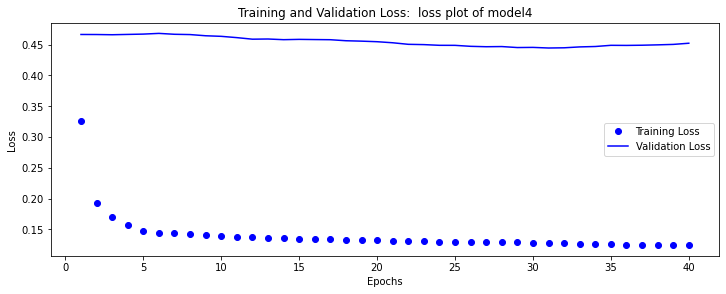

In [24]:
plot_simple_loss(model4_history, "loss plot of model4")

In [25]:
model5 = models.Sequential()
model5.add(layers.GRU(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

model5.add(layers.GRU(16, dropout=0.2, recurrent_dropout=0.2, activation='relu'))


model5.add(layers.Dense(1))

model5.compile(optimizer=RMSprop(), loss='mae')
model5_history = model5.fit(train_dataset, epochs=40, validation_data=val_dataset)

Epoch 1/40
9/9 [==============================] - 9s 441ms/step - loss: 0.8265 - val_loss: 0.5939
Epoch 2/40
9/9 [==============================] - 2s 274ms/step - loss: 0.3073 - val_loss: 0.5643
Epoch 3/40
9/9 [==============================] - 3s 348ms/step - loss: 0.2363 - val_loss: 0.5500
Epoch 4/40
9/9 [==============================] - 3s 283ms/step - loss: 0.2042 - val_loss: 0.5393
Epoch 5/40
9/9 [==============================] - 3s 286ms/step - loss: 0.2024 - val_loss: 0.5257
Epoch 6/40
9/9 [==============================] - 2s 269ms/step - loss: 0.2021 - val_loss: 0.5143
Epoch 7/40
9/9 [==============================] - 3s 286ms/step - loss: 0.1862 - val_loss: 0.5090
Epoch 8/40
9/9 [==============================] - 3s 286ms/step - loss: 0.1741 - val_loss: 0.5079
Epoch 9/40
9/9 [==============================] - 2s 279ms/step - loss: 0.1836 - val_loss: 0.5008
Epoch 10/40
9/9 [==============================] - 3s 281ms/step - loss: 0.1745 - val_loss: 0.4979
Epoch 11/40
9/9 [==

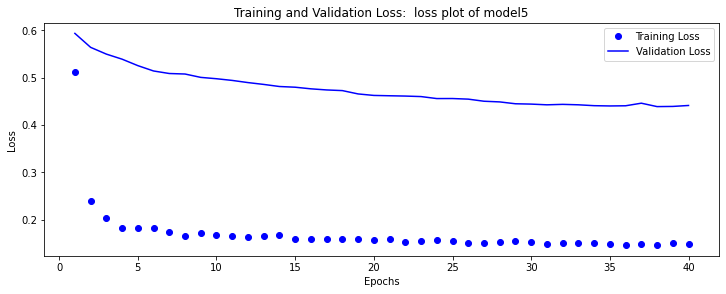

In [26]:
plot_simple_loss(model5_history, "loss plot of model5")

In [27]:
model6 = models.Sequential()
model6.add(layers.GRU(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

model6.add(layers.GRU(16, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, activation='relu'))
model6.add(layers.GRU(16, dropout=0.2, recurrent_dropout=0.2, activation='relu'))


model6.add(layers.Dense(1))

model6.compile(optimizer=RMSprop(), loss='mae')
model6_history = model6.fit(train_dataset, epochs=40, validation_data=val_dataset)

Epoch 1/40
9/9 [==============================] - 13s 466ms/step - loss: 1.0007 - val_loss: 0.7109
Epoch 2/40
9/9 [==============================] - 3s 371ms/step - loss: 0.6073 - val_loss: 0.7390
Epoch 3/40
9/9 [==============================] - 3s 375ms/step - loss: 0.3548 - val_loss: 0.7326
Epoch 4/40
9/9 [==============================] - 3s 374ms/step - loss: 0.2745 - val_loss: 0.7149
Epoch 5/40
9/9 [==============================] - 4s 407ms/step - loss: 0.2541 - val_loss: 0.6973
Epoch 6/40
9/9 [==============================] - 3s 377ms/step - loss: 0.2394 - val_loss: 0.6886
Epoch 7/40
9/9 [==============================] - 4s 409ms/step - loss: 0.2189 - val_loss: 0.6797
Epoch 8/40
9/9 [==============================] - 3s 371ms/step - loss: 0.2312 - val_loss: 0.6720
Epoch 9/40
9/9 [==============================] - 3s 389ms/step - loss: 0.2234 - val_loss: 0.6679
Epoch 10/40
9/9 [==============================] - 3s 371ms/step - loss: 0.2041 - val_loss: 0.6632
Epoch 11/40
9/9 [=

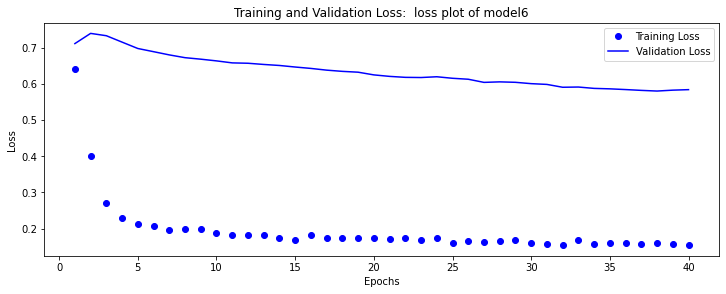

In [28]:
plot_simple_loss(model6_history, "loss plot of model6")

In [29]:
model7 = models.Sequential()
model7.add(layers.GRU(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

model7.add(layers.GRU(16, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, activation='relu'))
model7.add(layers.GRU(8, dropout=0.2, recurrent_dropout=0.2, activation='relu'))


model7.add(layers.Dense(1))

model7.compile(optimizer=RMSprop(), loss='mae')
model7_history = model7.fit(train_dataset, epochs=40, validation_data=val_dataset)

Epoch 1/40
9/9 [==============================] - 13s 450ms/step - loss: 0.8480 - val_loss: 0.6457
Epoch 2/40
9/9 [==============================] - 3s 375ms/step - loss: 0.5993 - val_loss: 0.6875
Epoch 3/40
9/9 [==============================] - 3s 366ms/step - loss: 0.3516 - val_loss: 0.6885
Epoch 4/40
9/9 [==============================] - 3s 379ms/step - loss: 0.2742 - val_loss: 0.6756
Epoch 5/40
9/9 [==============================] - 3s 380ms/step - loss: 0.2462 - val_loss: 0.6684
Epoch 6/40
9/9 [==============================] - 4s 454ms/step - loss: 0.2345 - val_loss: 0.6613
Epoch 7/40
9/9 [==============================] - 3s 363ms/step - loss: 0.2200 - val_loss: 0.6524
Epoch 8/40
9/9 [==============================] - 3s 367ms/step - loss: 0.2283 - val_loss: 0.6447
Epoch 9/40
9/9 [==============================] - 3s 373ms/step - loss: 0.2156 - val_loss: 0.6391
Epoch 10/40
9/9 [==============================] - 3s 350ms/step - loss: 0.1997 - val_loss: 0.6372
Epoch 11/40
9/9 [=

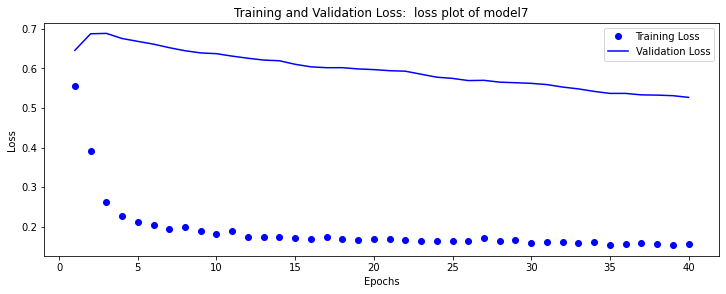

In [30]:
plot_simple_loss(model7_history, "loss plot of model7")

In [31]:
model8 = models.Sequential()
model8.add(layers.GRU(32, return_sequences=True, dropout=0.3, recurrent_dropout=0.3, input_shape=(shape_1, shape_2)))

model8.add(layers.GRU(16, dropout=0.3, recurrent_dropout=0.3, activation='relu'))


model8.add(layers.Dense(1))

model8.compile(optimizer=RMSprop(), loss='mae')
model8_history = model8.fit(train_dataset, epochs=40, validation_data=val_dataset)

Epoch 1/40
9/9 [==============================] - 10s 449ms/step - loss: 1.1121 - val_loss: 0.5387
Epoch 2/40
9/9 [==============================] - 2s 275ms/step - loss: 0.6395 - val_loss: 0.5199
Epoch 3/40
9/9 [==============================] - 2s 280ms/step - loss: 0.3625 - val_loss: 0.4942
Epoch 4/40
9/9 [==============================] - 3s 288ms/step - loss: 0.2912 - val_loss: 0.4784
Epoch 5/40
9/9 [==============================] - 3s 267ms/step - loss: 0.2432 - val_loss: 0.4627
Epoch 6/40
9/9 [==============================] - 2s 280ms/step - loss: 0.2346 - val_loss: 0.4470
Epoch 7/40
9/9 [==============================] - 3s 361ms/step - loss: 0.2246 - val_loss: 0.4395
Epoch 8/40
9/9 [==============================] - 3s 305ms/step - loss: 0.2115 - val_loss: 0.4368
Epoch 9/40
9/9 [==============================] - 3s 278ms/step - loss: 0.2042 - val_loss: 0.4328
Epoch 10/40
9/9 [==============================] - 4s 369ms/step - loss: 0.2063 - val_loss: 0.4245
Epoch 11/40
9/9 [=

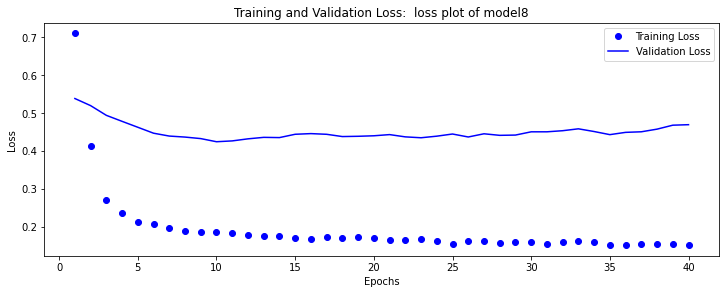

In [32]:
plot_simple_loss(model8_history, "loss plot of model8")

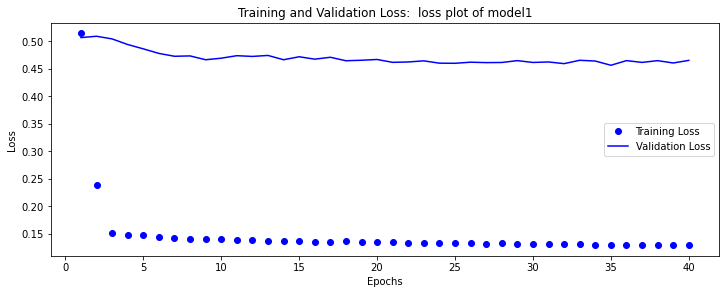

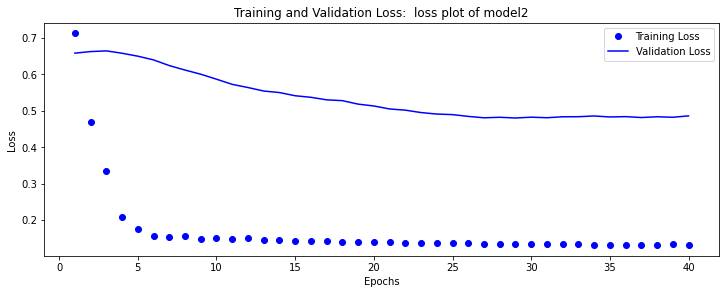

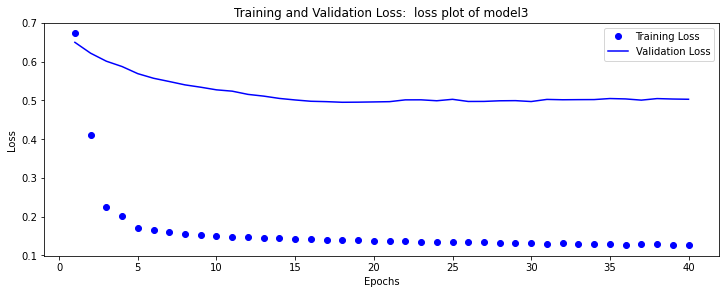

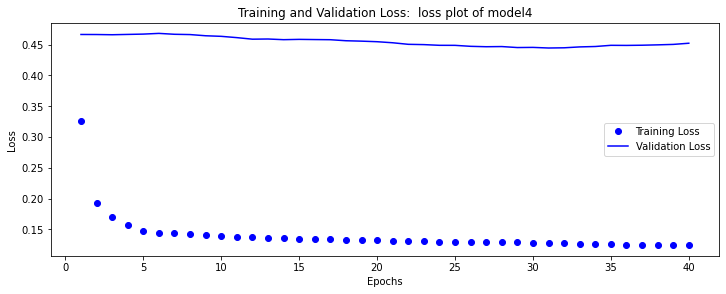

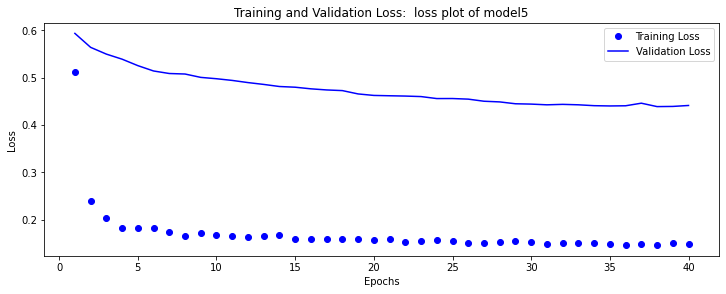

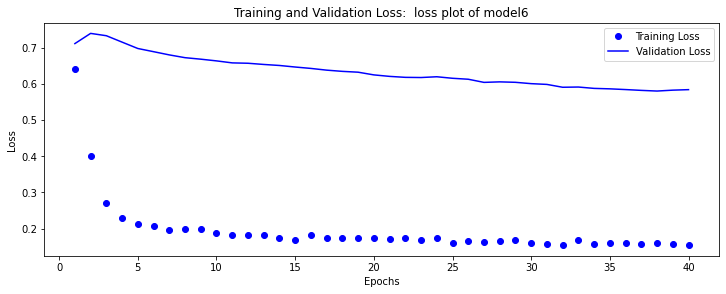

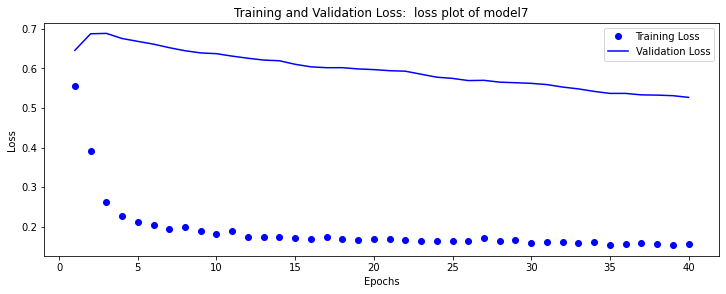

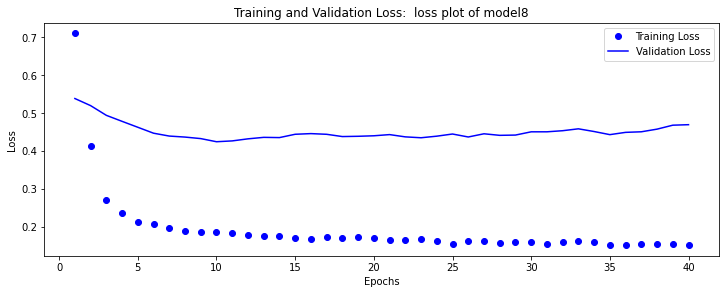

In [33]:
plot_simple_loss(model1_history, "loss plot of model1")
plot_simple_loss(model2_history, "loss plot of model2")
plot_simple_loss(model3_history, "loss plot of model3")
plot_simple_loss(model4_history, "loss plot of model4")
plot_simple_loss(model5_history, "loss plot of model5")
plot_simple_loss(model6_history, "loss plot of model6")
plot_simple_loss(model7_history, "loss plot of model7")
plot_simple_loss(model8_history, "loss plot of model8")